In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import os

from utils import (
    source_seq,
    generate_square_mask,
    generate_pupil,
    generate_Ein,
    fourier_transform,
    inv_fourier_transform,
    shift2D,
    shift2Dinv,
    midpoint_algo,
    xypos_to_idx,
    square_mask_inside,
    inside_revise_for_opt,
    inside_pixels_to_outside,
    optimization,
    optimization_torch
)

from typing import Tuple, Any
import numpy.typing as npt

plt.style.use(['science', 'ieee', 'no-latex'])

In [2]:
NA = 0.86
LAMBDA = 248
K = 2 * np.pi / LAMBDA
R = NA / np.float64(LAMBDA) # 0.003467741935483871
W = 200
THESHOLD = 0.5

In [3]:
f_max, samp1side = 0.05, 50
d_f = f_max / samp1side
s_max = 1 / (2 * d_f)
d_s = s_max / samp1side

In [4]:
s_seq, f_seq, sources = source_seq(s_max, f_max, samp1side, 1)
xx_space, yy_space = np.meshgrid(s_seq, s_seq)
xx_freq, yy_freq = np.meshgrid(f_seq, f_seq)
# sources
freq_pair = list(zip(xx_freq.flatten(), yy_freq.flatten()))
# I_dist
r, c = xx_space.flatten().shape[0], xx_freq.flatten().shape[0]
I_dist = np.zeros(shape=(r, c))

In [5]:
square_mask = generate_square_mask(s_seq, W)
pupil = generate_pupil(xx_freq, yy_freq, R)
square_mask.shape

(101, 101)

In [6]:
cnt = 0
for sinx, siny in freq_pair:
    # generate 2D Ein
    E_in = generate_Ein(K, xx_space, sinx, yy_space, siny)
    # Ein and the mask
    E_in_mask = E_in * square_mask
    # get E_out_unshift
    E_out_unshift = fourier_transform(E_in_mask)
    # E_out_pupil
    E_out_shift = shift2D(E_out_unshift)
    # E_out_pupil
    E_out_pupil = E_out_shift * pupil
    # E_out_pupil_unshift
    E_out_pupil_unshift = shift2Dinv(E_out_pupil)
    # get I
    I = inv_fourier_transform(E_out_pupil_unshift)
    I_abs = np.abs(I) ** 2
    I_abs_colv = I_abs.flatten()
    # put into I_dist
    I_dist[:, cnt] = I_abs_colv
    # add 1 for increase the index number of column
    cnt += 1

In [7]:
open_source = np.ones(shape=(I_dist.shape[1]))
normalize = open_source.shape[0]
I_out = np.dot(I_dist, open_source) / normalize

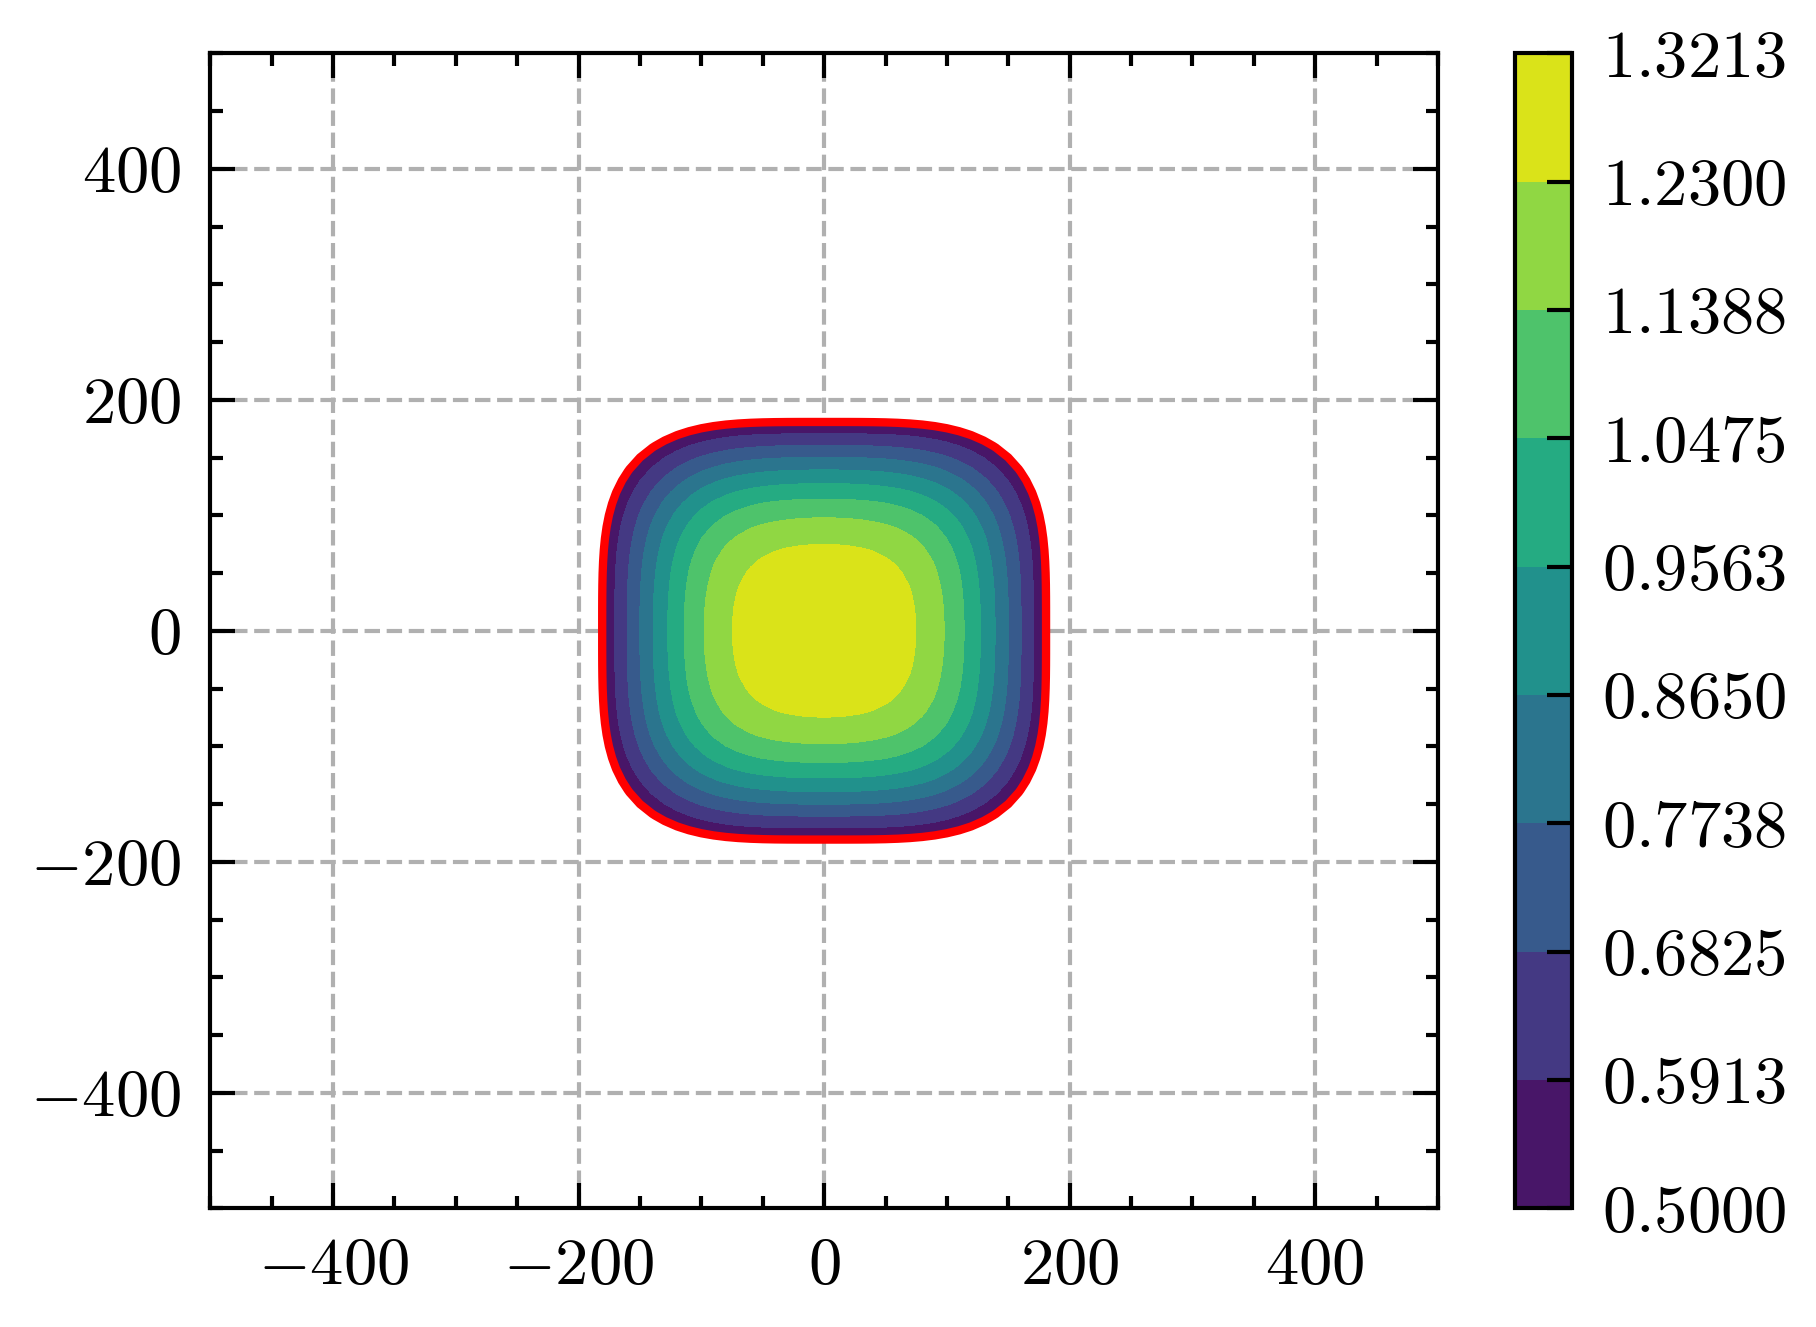

In [8]:
I_out_dist_2D = np.reshape(I_out, xx_space.shape)
plt.contourf(xx_space, yy_space, I_out_dist_2D, levels=np.linspace(0.5, I_out_dist_2D.max(), 10), zorder=5)
plt.colorbar()
plt.contour(xx_space, yy_space, I_out_dist_2D, levels=[0, 0.5], colors='red', zorder=5)
plt.grid(True, linestyle='--', zorder=0)

In [9]:
inside_pixels, l_of_inside = square_mask_inside(W, samp1side, d_s)
inside_rows = xypos_to_idx(inside_pixels)
# ICCin: inside marginal image
inside_rows = inside_revise_for_opt(l_of_inside, inside_rows)
in_ICC = I_dist[inside_rows, :]

In [10]:
outside_pixels = inside_pixels_to_outside(W, samp1side, d_s)
outside_rows = xypos_to_idx(outside_pixels)
# ICCout: outside marginal image
out_ICC = I_dist[outside_rows, :]

In [11]:
dark_pixels = midpoint_algo(samp1side, 4 * (2 * l_of_inside + 1))
dark_rows = xypos_to_idx(dark_pixels)
# ICC0: dark field binary intensity mask
dark_ICC = I_dist[dark_rows, :]

In [12]:
### Cheers! Got the final part
### Optimizations
# ---------- determine c1, c2, and other constant
c1d4 = 0.1
c1 = c1d4 * 4
c2 = 0.1
c2t2 = 2 * c2
d = 0.01
# ---------- optimization targets
inPout = in_ICC + out_ICC
tr = THESHOLD * np.ones(shape=(4 * (2 * l_of_inside + 1), 1))
delta = d * np.ones(shape=(4 * (2 * l_of_inside + 1), 1))
# ---------- quadratic form
Q = c1d4 * np.dot(inPout.transpose(), inPout) + c2 * np.dot(dark_ICC.transpose(), dark_ICC)
b = c1 * np.dot(inPout.transpose(), tr) + c2t2 * np.dot(dark_ICC.transpose(), delta)
c = c1 * np.dot(tr.transpose(), tr) + c2 * np.dot(delta.transpose(), delta)

In [13]:
Q.shape

(10201, 10201)

In [14]:
# conjugate gradient
J = optimization(Q, b)

opt_result = np.dot(I_dist, J)
I_out_dist_2D = np.reshape(I_out, xx_space.shape)
plt.contourf(xx_space, yy_space, I_out_dist_2D, levels=np.linspace(0.5, I_out_dist_2D.max(), 10), zorder=5)
plt.colorbar()
plt.contour(xx_space, yy_space, I_out_dist_2D, levels=[0, 0.5], colors='red', zorder=5)
plt.grid(True, linestyle='--', zorder=0)